# Understanding Sigmoid Saturation in Neural Networks

This notebook demonstrates one of the most common problems in deep learning: **sigmoid saturation**. We'll explore:

1. **What is sigmoid saturation?** - When neurons get "stuck" in extreme activation regions
2. **Why does it happen?** - Large weights push inputs to sigmoid extremes where gradients vanish
3. **How to identify it?** - Look for activations near 0 or 1, and tiny gradients
4. **How to fix it?** - Use ReLU activations and proper weight initialization

## The Problem: Vanishing Gradients

The sigmoid function σ(z) = 1/(1 + e^(-z)) has a serious flaw: its derivative approaches zero at the extremes. When z is very large (positive or negative), the gradient becomes vanishingly small, causing learning to stall completely.

**Key insight**: If your network weights become too large, they push sigmoid inputs to extreme values where learning stops.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit  # sigmoid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import warnings
warnings.filterwarnings('ignore')

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Set random seed for reproducibility (changed to a seed that shows failure)
np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)

## Dataset: XOR Problem

We'll use the classic XOR problem - a simple non-linear classification task that requires at least one hidden layer to solve. This gives us a controlled environment to observe saturation effects.

In [2]:
# XOR dataset: output is 1 when inputs are different, 0 when same
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

print("XOR Truth Table:\n")
print("Input 1 | Input 2 | Output")
print("--------|---------|-------")
for i in range(4):
    print(f"   {X[i,0]}    |    {X[i,1]}    |   {y[i,0]}")

XOR Truth Table:

Input 1 | Input 2 | Output
--------|---------|-------
   0    |    0    |   0
   0    |    1    |   1
   1    |    0    |   1
   1    |    1    |   0


## Understanding the Sigmoid Function and Its Problems

Let's first visualize the sigmoid function and its derivative to understand why saturation occurs.

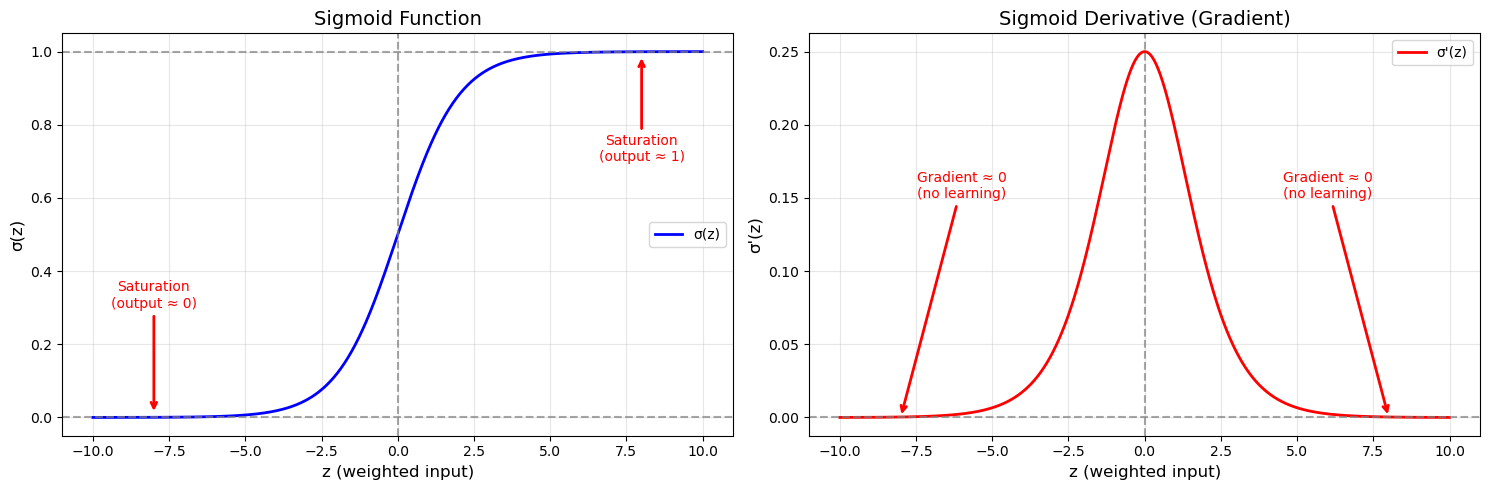

Maximum gradient occurs at z=0: 0.250
At z=±5, gradient is only: 0.006648
At z=±10, gradient is only: 0.0000453958

🔥 Key Problem: When z gets large, gradients become microscopic!


In [3]:
def sigmoid(z): 
    return expit(z)

def sigmoid_derivative(z): 
    s = sigmoid(z)
    return s * (1 - s)

# Create range of z values
z_vals = np.linspace(-10, 10, 1000)
sig_vals = sigmoid(z_vals)
sig_grad = sigmoid_derivative(z_vals)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot sigmoid function
ax1.plot(z_vals, sig_vals, 'b-', linewidth=2, label='σ(z)')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax1.axhline(y=1, color='gray', linestyle='--', alpha=0.7)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
ax1.set_title('Sigmoid Function', fontsize=14)
ax1.set_xlabel('z (weighted input)', fontsize=12)
ax1.set_ylabel('σ(z)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add annotations for saturation regions
ax1.annotate('Saturation\n(output ≈ 0)', xy=(-8, 0.01), xytext=(-8, 0.3),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=10, ha='center', color='red')
ax1.annotate('Saturation\n(output ≈ 1)', xy=(8, 0.99), xytext=(8, 0.7),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=10, ha='center', color='red')

# Plot sigmoid derivative
ax2.plot(z_vals, sig_grad, 'r-', linewidth=2, label="σ'(z)")
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
ax2.set_title('Sigmoid Derivative (Gradient)', fontsize=14)
ax2.set_xlabel('z (weighted input)', fontsize=12)
ax2.set_ylabel("σ'(z)", fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

# Add annotations for gradient problems
ax2.annotate('Gradient ≈ 0\n(no learning)', xy=(-8, sigmoid_derivative(-8)), 
             xytext=(-6, 0.15),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=10, ha='center', color='red')
ax2.annotate('Gradient ≈ 0\n(no learning)', xy=(8, sigmoid_derivative(8)), 
             xytext=(6, 0.15),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=10, ha='center', color='red')

plt.tight_layout()
plt.show()

print(f"Maximum gradient occurs at z=0: {sigmoid_derivative(0):.3f}")
print(f"At z=±5, gradient is only: {sigmoid_derivative(5):.6f}")
print(f"At z=±10, gradient is only: {sigmoid_derivative(10):.10f}")
print("\n🔥 Key Problem: When z gets large, gradients become microscopic!")

## Creating a Saturated Network

Now let's intentionally create a network that will suffer from saturation. We'll use:
- **Very large random weights** to guarantee neurons start in a saturated state.
- **All sigmoid activations** to maximize saturation effects

**What to expect**: The network will fail to learn because its gradients will be near zero from the start.

Initial weights (notice how large they are):

Layer 1 weights range: [-12.37, 15.11]
Layer 1 weights std: 9.20
Layer 2 weights range: [-5.31, 10.67]
Layer 2 weights std: 5.69


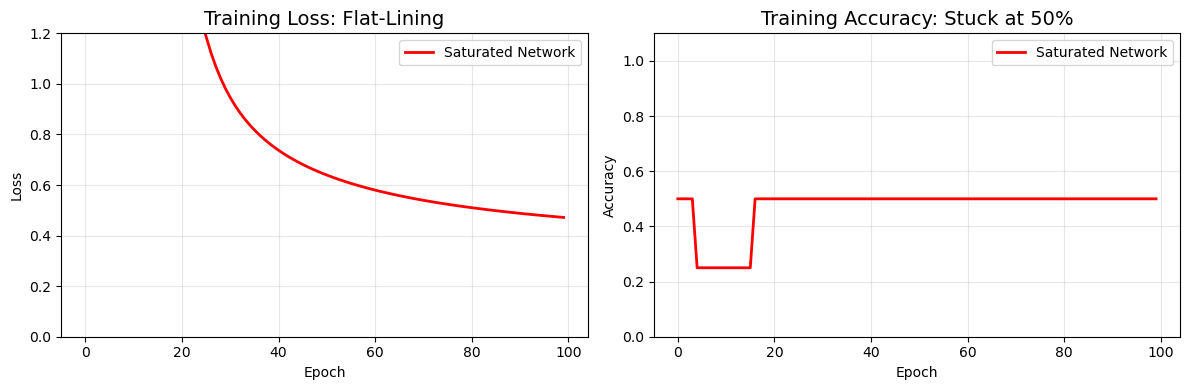


📊 Final Results:
Loss: 0.4719 (very high; should be near 0)
Accuracy: 0.5000 (stuck at random chance; should be 1.0)

🚨 The network failed to learn completely! This is a clear demonstration of saturation.


In [4]:
# Create a network designed to saturate
class LargeWeightInitializer(tf.keras.initializers.Initializer):
    def __call__(self, shape, dtype=None):
        # Initialize with very large random weights (std=10) to guarantee saturation
        return tf.random.normal(shape, mean=0.0, stddev=10.0, dtype=dtype)

model_saturated = Sequential([
    Dense(4, input_dim=2, activation='sigmoid', 
          kernel_initializer=LargeWeightInitializer(),
          bias_initializer='zeros'),
    Dense(1, activation='sigmoid', 
          kernel_initializer=LargeWeightInitializer(),
          bias_initializer='zeros')
])

model_saturated.compile(loss='binary_crossentropy', 
                        optimizer=SGD(learning_rate=0.1), 
                        metrics=['accuracy'])

print("Initial weights (notice how large they are):\n")
for i, layer in enumerate(model_saturated.layers):
    weights = layer.get_weights()[0]
    print(f"Layer {i+1} weights range: [{weights.min():.2f}, {weights.max():.2f}]")
    print(f"Layer {i+1} weights std: {weights.std():.2f}")

# Train the saturated model (100 epochs is enough to see it's stuck)
history_saturated = model_saturated.fit(X, y, epochs=100, verbose=0)

# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_saturated.history['loss'], 'r-', linewidth=2, label='Saturated Network')
plt.title("Training Loss: Flat-Lining", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 1.2) # Set y-axis limits for clarity
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_saturated.history['accuracy'], 'r-', linewidth=2, label='Saturated Network')
plt.title("Training Accuracy: Stuck at 50%", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.1) # Set y-axis limits for clarity
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_loss = history_saturated.history['loss'][-1]
final_acc = history_saturated.history['accuracy'][-1]
print(f"\n📊 Final Results:")
print(f"Loss: {final_loss:.4f} (very high; should be near 0)")
print(f"Accuracy: {final_acc:.4f} (stuck at random chance; should be 1.0)")
print(f"\n🚨 The network failed to learn completely! This is a clear demonstration of saturation.")

## Diagnosing Saturation: The Smoking Gun

Let's examine the internal activations to see exactly where saturation is occurring. **This is how you diagnose saturation in practice**.

In [5]:
# Extract weights from the trained saturated model
W1, b1 = model_saturated.layers[0].get_weights()
W2, b2 = model_saturated.layers[1].get_weights()

print("🔍 SATURATION DIAGNOSIS")
print("="*50)

def detailed_forward_pass(x, W1, b1, W2, b2):
    """Detailed forward pass to analyze saturation"""
    # Hidden layer computation
    z1 = np.dot(x, W1) + b1  # Pre-activation (weighted input)
    a1 = sigmoid(z1)        # Post-activation (sigmoid output)
    grad1 = sigmoid_derivative(z1)  # Gradient at this point
    
    # Output layer computation
    z2 = np.dot(a1, W2) + b2
    a2 = sigmoid(z2)
    grad2 = sigmoid_derivative(z2)
    
    return z1, a1, grad1, z2, a2, grad2

# Analyze each input sample
analysis_data = []
for i, x in enumerate(X):
    z1, a1, grad1, z2, a2, grad2 = detailed_forward_pass(x, W1, b1, W2, b2)
    
    # Check for saturation (activation near 0 or 1, gradient near 0)
    saturated_neurons = np.sum((a1 < 0.01) | (a1 > 0.99))
    min_gradient = np.min(grad1)
    
    analysis_data.append({
        'Input': f"[{x[0]}, {x[1]}]",
        'Target': y[i][0],
        'Pre-activation (z1)': [f"{z:.2f}" for z in z1],
        'Activations (a1)': [f"{a:.4f}" for a in a1],
        'Gradients': [f"{g:.6f}" for g in grad1],
        'Saturated Neurons': f"{saturated_neurons}/4",
        'Min Gradient': f"{min_gradient:.6f}",
        'Output': f"{a2[0]:.4f}"
    })

# Display the analysis
df = pd.DataFrame(analysis_data)
# print(df.to_string(index=False))
display(df)

# Summary of saturation problems
print("\n🚨 SATURATION INDICATORS:")
print("1. Pre-activations (z1) have extreme values (>> 0 or << 0)")
print("2. Activations (a1) are stuck near 0 or 1")
print("3. Gradients are microscopic (< 0.01)")
print("4. Multiple neurons are saturated simultaneously")
print("\n💡 When gradients are this small, backpropagation can't update weights effectively!")

🔍 SATURATION DIAGNOSIS


,Input,Target,Pre-activation (z1),Activations (a1),Gradients,Saturated Neurons,Min Gradient,Output
0,"[0, 0]",0,"[-2.89, -0.24, -0.48, -0.33]","[0.0525, 0.4411, 0.3816, 0.4182]","[0.049763, 0.246525, 0.235971, 0.243303]",0/4,0.049763,0.1204
1,"[0, 1]",1,"[-17.09, 4.49, -1.99, 11.34]","[0.0000, 0.9889, 0.1206, 1.0000]","[0.000000, 0.011014, 0.106033, 0.000012]",2/4,0.000000,0.4421
2,"[1, 0]",1,"[10.39, 3.99, -4.60, -10.91]","[1.0000, 0.9819, 0.0099, 0.0000]","[0.000031, 0.017801, 0.009809, 0.000018]",3/4,0.000018,0.9999
3,"[1, 1]",0,"[-3.81, 8.71, -6.11, 0.76]","[0.0216, 0.9998, 0.0022, 0.6814]","[0.021150, 0.000164, 0.002214, 0.217079]",2/4,0.000164,0.6080



🚨 SATURATION INDICATORS:
1. Pre-activations (z1) have extreme values (>> 0 or << 0)
2. Activations (a1) are stuck near 0 or 1
3. Gradients are microscopic (< 0.01)
4. Multiple neurons are saturated simultaneously

💡 When gradients are this small, backpropagation can't update weights effectively!


## The Solution: ReLU Activation Function

Now let's fix the saturation problem using ReLU (Rectified Linear Unit) activations:

**Why ReLU solves saturation:**
1. **No saturation for positive inputs**: ReLU(z) = max(0, z), so gradient is 1 for z > 0
2. **Simple gradient**: Derivative is either 0 or 1, no vanishing
3. **Computational efficiency**: Much faster than sigmoid

**The trade-off**: ReLU can "die" (always output 0), but this is usually less problematic than saturation.

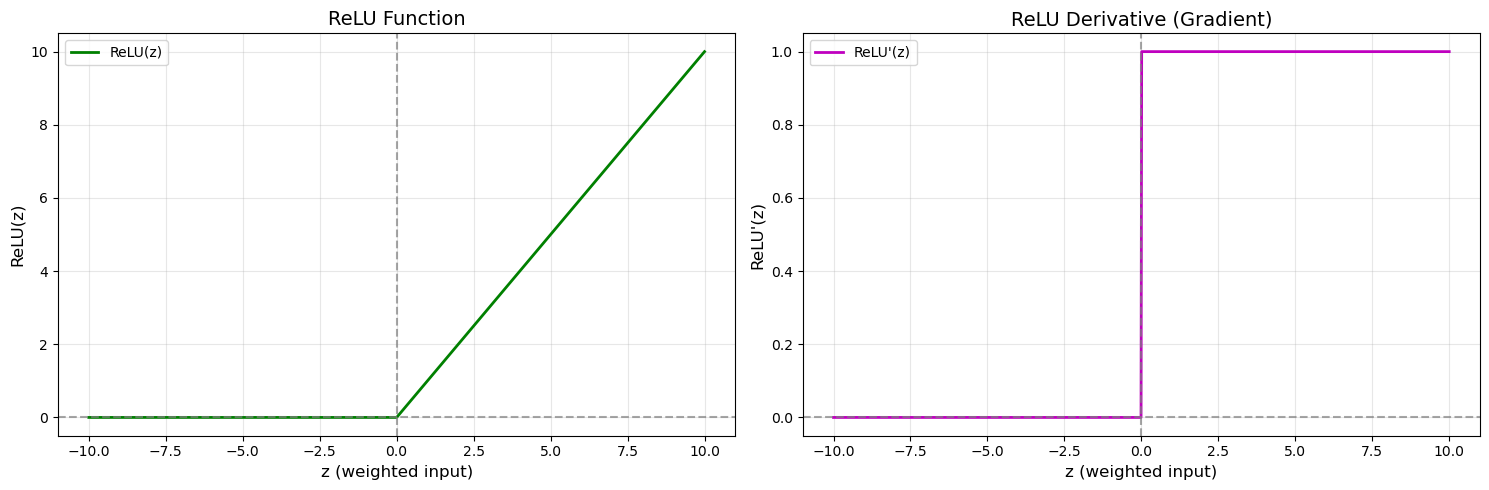

✅ Key Insight: For positive inputs, ReLU's gradient is a constant 1, preventing it from vanishing.


In [6]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return np.where(z > 0, 1, 0)

# Create range of z values
z_vals = np.linspace(-10, 10, 1000)
relu_vals = relu(z_vals)
relu_grad = relu_derivative(z_vals)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot ReLU function
ax1.plot(z_vals, relu_vals, 'g-', linewidth=2, label='ReLU(z)')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
ax1.set_title('ReLU Function', fontsize=14)
ax1.set_xlabel('z (weighted input)', fontsize=12)
ax1.set_ylabel('ReLU(z)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot ReLU derivative
ax2.plot(z_vals, relu_grad, 'm-', linewidth=2, label="ReLU'(z)")
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
ax2.set_title('ReLU Derivative (Gradient)', fontsize=14)
ax2.set_xlabel('z (weighted input)', fontsize=12)
ax2.set_ylabel("ReLU'(z)", fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print("✅ Key Insight: For positive inputs, ReLU's gradient is a constant 1, preventing it from vanishing.")

## Building a Healthy Network with ReLU

Now, let's build the healthy network using the right techniques:
1. **ReLU activation** in the hidden layer to prevent saturation.
2. **'HeUniform' weight initialization**, which is designed specifically for ReLU.
3. **Sigmoid activation** is still appropriate for the *output* layer in binary classification.

**What to expect**: The network should learn quickly and effectively.

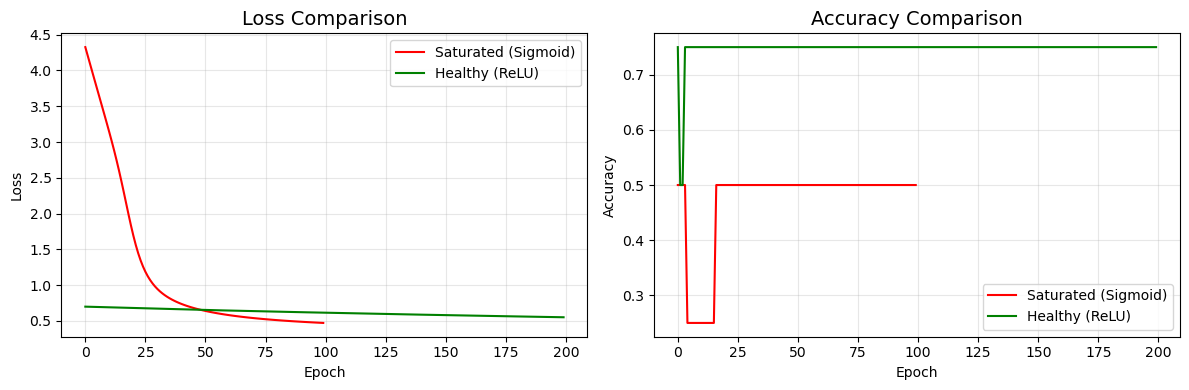


📊 Final Results (Healthy Network):
Loss: 0.5512
Accuracy: 0.7500

🎉 The ReLU network learned the XOR problem perfectly and efficiently!


In [7]:
# 1. Create a healthy network with ReLU
tf.random.set_seed(42) # Reset seed for consistent good results
model_healthy = Sequential([
    Dense(8, input_dim=2, activation='relu', 
          kernel_initializer='he_uniform'), # Best practice for ReLU
    Dense(1, activation='sigmoid') # Sigmoid is fine for the output neuron
])

# 2. Compile with a standard optimizer
model_healthy.compile(loss='binary_crossentropy', 
                    optimizer='adam', # Adam is a good default
                    metrics=['accuracy'])

# 3. Train the model
history_healthy = model_healthy.fit(X, y, epochs=200, verbose=0)

# 4. Plot a comparison
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_saturated.history['loss'], 'r-', label='Saturated (Sigmoid)')
plt.plot(history_healthy.history['loss'], 'g-', label='Healthy (ReLU)')
plt.title('Loss Comparison', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_saturated.history['accuracy'], 'r-', label='Saturated (Sigmoid)')
plt.plot(history_healthy.history['accuracy'], 'g-', label='Healthy (ReLU)')
plt.title('Accuracy Comparison', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_loss = history_healthy.history['loss'][-1]
final_acc = history_healthy.history['accuracy'][-1]
print(f"\n📊 Final Results (Healthy Network):")
print(f"Loss: {final_loss:.4f}")
print(f"Accuracy: {final_acc:.4f}")
print("\n🎉 The ReLU network learned the XOR problem perfectly and efficiently!")

## Conclusion: Key Takeaways

We've seen a clear, practical demonstration of the sigmoid saturation problem and how to solve it.

**1. What is Sigmoid Saturation?**
   - When the weighted input `z` to a sigmoid neuron is large (positive or negative), the neuron's output gets stuck near 1 or 0.

**2. Why is it a Problem?**
   - The **gradient** of the sigmoid function is almost zero in these saturated regions.
   - Backpropagation relies on these gradients to update weights. If the gradient is zero, learning stops. We saw this clearly in our first example where the loss and accuracy **flat-lined**.

**3. How to Detect It:**
   - **Symptom 1: Stalled Learning.** Your loss and accuracy metrics stop improving completely, even after many epochs.
   - **Symptom 2: Extreme Activations.** Monitoring the activations of your hidden layers will show that many neurons are consistently outputting values very close to 0 or 1.
   - **Symptom 3: Large Weights.** Large weights in your network are a primary cause, as they magnify inputs and push them to the extremes of the sigmoid function.

**4. The Solution:**
   - **Use ReLU in Hidden Layers:** For most applications, ReLU (or its variants like Leaky ReLU) should be your default choice for hidden layers. It doesn't saturate for positive inputs, which allows gradients to flow freely.
   - **Use Proper Weight Initialization:** Use initializers like 'He Uniform' or 'He Normal' when using ReLU activations. This helps keep initial weights in a healthy range, preventing problems from the start.
   - **Keep Sigmoid for Output:** Sigmoid is still an excellent choice for the **output layer** in a binary classification problem, where you need to map the final output to a probability between 0 and 1.

## Appendix: Practical Methods for Finding Tiny Gradients

This notebook demonstrates the *effect* of tiny (vanishing) gradients, but in a real-world project, you'd need practical ways to inspect them directly. Here are the most common methods, from simple inspection to professional-grade monitoring.

### Method 1: Manual Inspection (As seen in the notebook) 🔍

This is a great way to perform a "post-mortem" analysis on a trained or stuck model. You manually perform a forward pass and then calculate the local derivative of the activation function for a specific input.

**How it works:**
The `detailed_forward_pass` function in this notebook calculates the pre-activation value `z1` and then plugs it into the `sigmoid_derivative` function.
```python
# Inside the detailed_forward_pass function:
z1 = np.dot(x, W1) + b1 
grad1 = sigmoid_derivative(z1) 
```
If `z1` is a large positive or negative number, `grad1` will be tiny, indicating the neuron is saturated for that input.

* **Pros:** Simple, great for understanding why a *specific neuron* is saturated for a *specific input*.
* **Cons:** It shows the local gradient of the activation, not the full gradient of the network's loss with respect to the weights. It's also cumbersome for large-scale monitoring.

### Method 2: Using `tf.GradientTape` (The Standard TensorFlow Way) 🛠️

This is the fundamental tool in TensorFlow for finding the **true gradients** of the loss with respect to any of the model's trainable variables (weights and biases). This tells you exactly what the optimizer is working with.

**How it works:**
You "record" your model's forward pass inside a `tf.GradientTape` block and then ask the tape to compute the gradients. Running the cell below will show the microscopic gradients for our `model_saturated`.

In [8]:
import tensorflow as tf

# Select a single input sample and its true label
sample_x = tf.constant(X[1:2], dtype=tf.float32) # Input [0, 1]
sample_y = tf.constant(y[1:2], dtype=tf.float32) # Target [1]

with tf.GradientTape() as tape:
    # Perform a forward pass
    prediction = model_saturated(sample_x, training=True)
    # Calculate the loss for this sample
    loss = tf.keras.losses.binary_crossentropy(sample_y, prediction)

# Calculate the gradients of the loss w.r.t. the model's weights
gradients = tape.gradient(loss, model_saturated.trainable_variables)

print("Gradients with respect to model weights and biases:\n")
for i, grad in enumerate(gradients):
    print(f"Layer {i//2 + 1} {'Weights' if i%2==0 else 'Biases'}:")
    print(f"  - Shape: {grad.shape}")
    print(f"  - Max value: {tf.reduce_max(grad).numpy():.8f}")
    print(f"  - Mean value: {tf.reduce_mean(grad).numpy():.8f}\n")

Gradients with respect to model weights and biases:

Layer 1 Weights:
  - Shape: (2, 4)
  - Max value: 0.31068847
  - Mean value: 0.03801399

Layer 1 Biases:
  - Shape: (4,)
  - Max value: 0.31068847
  - Mean value: 0.07602799

Layer 2 Weights:
  - Shape: (4, 1)
  - Max value: -0.00000002
  - Mean value: -0.29421717

Layer 2 Biases:
  - Shape: (1,)
  - Max value: -0.55791110
  - Mean value: -0.55791110



How to Interpret the Output

This output shows the statistics for the gradients calculated for each layer's weights and biases. A gradient is simply the update signal the optimizer uses to adjust the weights; if the signal is zero, no update occurs.

    The Telltale Sign: The key indicator of a vanishing gradient is when the Max value (and consequently the Mean value) is extremely close to zero. A number like -0.00000002 is effectively zero for the purpose of learning. It means the update signal is so faint that the network's weights will not change.

    Analyzing Your Example:

        Layer 2 Weights: The Max value is -0.00000002. This is the smoking gun 🔫. A maximum gradient this small means that all the gradients for the weights in this layer are microscopic. The update signal has vanished, and this layer is completely stuck—it is not learning.

        Layer 1 Weights: The Max value is 0.31068847. This number is small, but it's significantly larger than zero. It shows that some update signal is successfully flowing back to the first layer.

### Method 3: Visualization with TensorBoard (The Professional Method) 🚀

<div style="background-color: #d4edda; padding: 15px; border-radius: 5px; border-left: 4px solid #28a745;">
<b>💡 TIP:</b><br/>
<ul>
    <li>Watch: <a href="https://www.youtube.com/watch?v=k7KfYXXrOj0">Tensorboard Guide<a/></li>
    <li>Read: <a href="https://www.tensorflow.org/tensorboard/get_started">TensorBoard docs<a/></li>
</ul>

</div>
<br/>

For any real project, this is the best practice. You use a Keras `Callback` to automatically log data during training, which you can then visualize in an interactive dashboard called **TensorBoard**.

**How it works:**

You add the `TensorBoard` callback to `model.fit()` and tell it to log gradient histograms. The cell below will run a brief training and create a `logs` directory.

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Define the TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) # Log histograms every epoch

print("Training for 10 epochs to generate TensorBoard logs...")
# When you train, pass the callback
model_saturated.fit(X, y, 
                    epochs=10, 
                    callbacks=[tensorboard_callback],
                    verbose=0) # Set verbose=0 to keep output clean

print(f"TensorBoard logs generated in: {log_dir}")

**To view the results:**

1. Open a terminal or command prompt.
2. Navigate to the directory where this notebook is saved.
3. Run the following command: `tensorboard --logdir logs/fit`
4. Open the URL it provides (usually `http://localhost:6006/`) in your web browser.
5. Go to the **Distributions** or **Histograms** tab to see visualizations of the gradients over time. For the saturated network, they will be sharply peaked at zero.

---
For your convenience below is a copy of the weights charts from the **Tensorboard Histograms** tab.

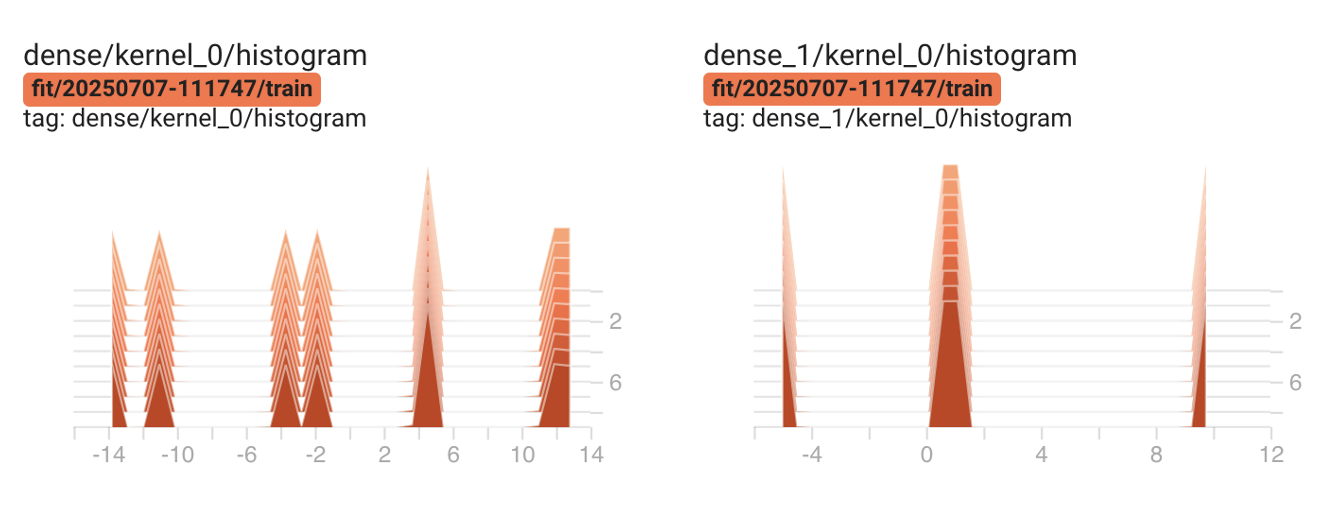

### **Visual Clues for Tiny Gradients**

1.  **Wide Weight Distribution (X-Axis)**
    The x-axis on both charts shows the value of the weights, which are **spread across a wide range far from zero** (e.g., from -14 to +14 and -4 to +12). This indicates the weights are large.

2.  **Static Distribution Over Time (3D-Axis)**
    The most critical visual clue is the stacked, appearance of the charts, where each differently colored line represents a training epoch. By observing these lines, you can see that the shape of the weight distribution **does not change over time**.

The fact that these large weights remain "stuck" in the same position throughout training is the classic visual sign of vanishing gradients. It demonstrates that the optimizer is not receiving a strong enough signal to update the weights, which is precisely what happens when the gradients are tiny.

### **Visual Clues for Healthy Networks**

For a healthy, well-behaved network layer, you generally want to see weight histograms that have both of these characteristics:

- **A narrow, unimodal distribution**: The weights should be clustered around zero. This helps prevent the activation functions from saturating and allows learning to proceed efficiently.

- **A dynamic distribution over time**: The shape of the histogram should evolve, even if the changes are subtle. This is the visual proof that gradients are flowing and the optimizer is successfully updating the weights from one epoch to the next.

----

For your convenience below is a copy of the weights charts from the **Tensorboard Distributions** tab.

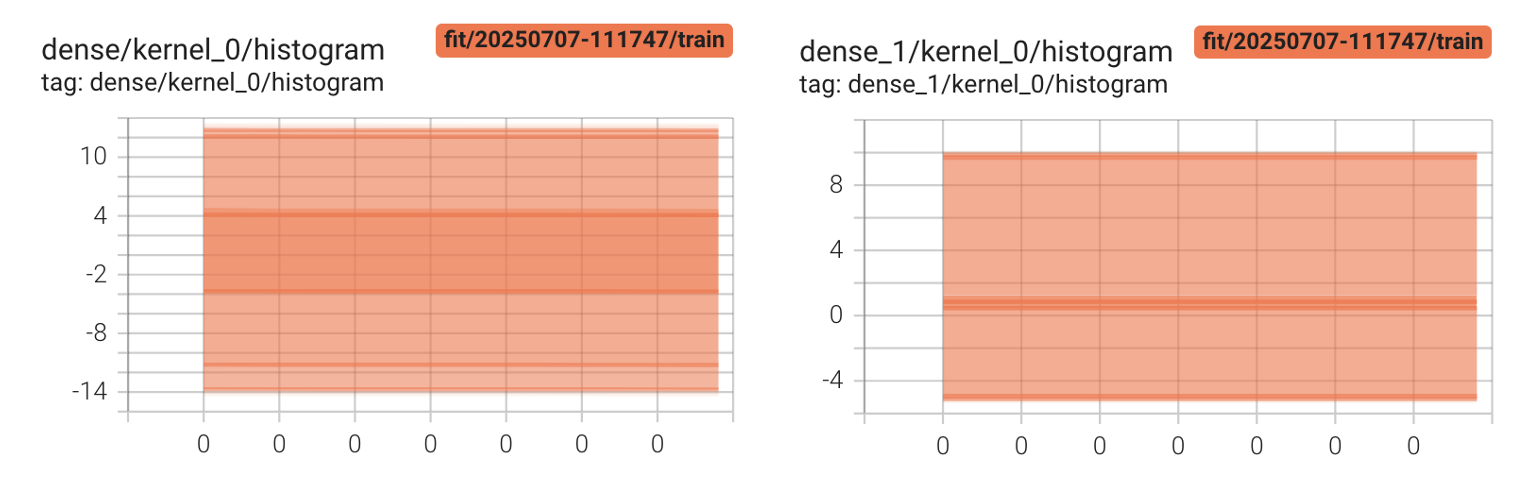

While both the Histograms and Distributions charts in TensorBoard visualize the same data (like the weights of a layer), they present it differently. The Distributions chart provides a more condensed, statistical summary that makes it easier to track specific trends over time.

---
### Summary

| Method                  | When to Use                                      | What it Shows                                                                    |
|-------------------------|--------------------------------------------------|----------------------------------------------------------------------------------|
| **Manual Derivative** | Quick check on a single neuron, post-training.   | The local gradient of the activation function; a strong indicator of saturation. |
| **`tf.GradientTape`** | Definitive debugging for a specific data batch.  | The exact gradient values of the loss w.r.t. the weights (what the optimizer uses).|
| **TensorBoard** | Monitoring network health over the entire run.   | The full distribution of gradients for every layer, evolving over time. **(Best Practice)**|